# 💪 Sports Center 고객 정보 분석 - 2
## II. 고객의 행동을 예측!

## ✔ 문제 상황 
### VOC (Voice of Customer)
- 고객별 이용 횟수를 예측할 수 있을까?

### 사용 할 데이터
- use_log.csv
- customer_join.csv

## ✔ Solution

## STEP1. 데이터 읽어오기

In [1]:
import pandas as pd

In [2]:
uselog = pd.read_csv('./use_log.csv')
uselog.isnull().sum() / len(uselog)

log_id         0.0
customer_id    0.0
usedate        0.0
dtype: float64

In [3]:
uselog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   log_id       197428 non-null  object
 1   customer_id  197428 non-null  object
 2   usedate      197428 non-null  object
dtypes: object(3)
memory usage: 4.5+ MB


In [4]:
customer = pd.read_csv('./customer_join.csv')
customer.isnull().sum() / len(customer)

customer_id          0.000000
name                 0.000000
class                0.000000
gender               0.000000
start_date           0.000000
end_date             0.677958
campaign_id          0.000000
is_deleted           0.000000
class_name           0.000000
price                0.000000
campaign_name        0.000000
mean                 0.000000
median               0.000000
max                  0.000000
min                  0.000000
routine_flg          0.000000
calc_date            0.000000
membership_period    0.000000
dtype: float64

In [5]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        4192 non-null   object 
 1   name               4192 non-null   object 
 2   class              4192 non-null   object 
 3   gender             4192 non-null   object 
 4   start_date         4192 non-null   object 
 5   end_date           1350 non-null   object 
 6   campaign_id        4192 non-null   object 
 7   is_deleted         4192 non-null   int64  
 8   class_name         4192 non-null   object 
 9   price              4192 non-null   int64  
 10  campaign_name      4192 non-null   object 
 11  mean               4192 non-null   float64
 12  median             4192 non-null   float64
 13  max                4192 non-null   int64  
 14  min                4192 non-null   int64  
 15  routine_flg        4192 non-null   int64  
 16  calc_date          4192 

## STEP2. 클러스터링으로 회원을 그룹화
- 탈퇴 여부로 분류x,  이용 이력을 통해 그룹화
- 진짜 결측인지, 탈퇴 하지 않은 것인지 부정확하기 때문

In [6]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head(3)

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47


In [7]:
!conda list scikit-learn

# packages in environment at C:\Users\admin\anaconda3:
#
# Name                    Version                   Build  Channel
scikit-learn              0.24.1           py38hf11a4ad_0  


In [8]:
!conda install -c anaconda scikit-learn -y

Solving environment: ...working... done

# All requested packages already installed.



In [14]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [10]:
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

In [11]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)

In [15]:
customer_clustering['cluster'] = clusters.labels_

In [16]:
customer_clustering['cluster'].unique()

array([1, 2, 3, 0])

In [17]:
customer_clustering.head(3)

,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1


In [18]:
customer_clustering.columns = ['월평균값', '월중앙값', '월최댓값', '월최솟값', '회원기간', 'cluster']
customer_clustering.groupby('cluster').count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [19]:
# 그룹 0 : 평균 이용 횟수가 높고 기간이 짧다. -> 막 가입 한 회원
# 그룹 1 : 평균 이용 횟수가 적고 기간이 길다. -> 꾸준이 나오는 안정적인 회원
# 그룹 2 : 평균 이용 횟수가 적고 기간이 잛다. -> 번아웃 상태 회원
# 그룹 3 : 평균 이용 횟수가 보통이고 기간이 길다. -> 꾸준이 나오는 회원
customer_clustering.groupby('cluster').mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


## STEP3. 클러스터링 결과를 시각화
- 5개의 변수를 2차원으로 차원 축소

In [20]:
from sklearn.decomposition import PCA

In [21]:
X = customer_clustering_sc
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)
x_pca

array([[-0.81998232, -1.95909657],
       [-0.70792183, -1.79985685],
       [-1.06149902, -1.65982605],
       ...,
       [ 3.02793307,  1.13963534],
       [ 6.08311415,  0.58470806],
       [ 5.06472045,  0.76968382]])

In [23]:
pca_df = pd.DataFrame(x_pca)

In [24]:
pca_df['cluster'] = customer_clustering['cluster']

In [25]:
pca_df.head()

,0,1,cluster
0,-0.819982,-1.959097,1
1,-0.707922,-1.799857,1
2,-1.061499,-1.659826,1
3,-1.160764,-1.810139,1
4,-2.017132,-1.670101,1


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

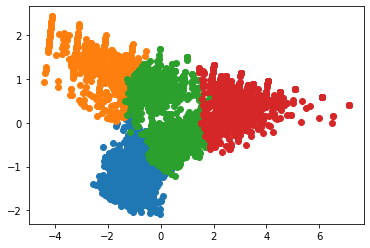

In [27]:
for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster'] == i]
    plt.scatter(tmp[0], tmp[1])

## STEP4. Clustering 결과 바탕으로 탈퇴회원의 경향 분석
- 지속회원과 탈퇴회원을 집계

In [28]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)

In [29]:
customer_clustering.head(3)

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster,customer_id,name,class,gender,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,4.833333,5.0,8,2,47,1,OA832399,XXXX,C01,F,...,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,5.083333,5.0,7,3,47,1,PL270116,XXXXX,C01,M,...,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,4.583333,5.0,6,3,47,1,OA974876,XXXXX,C01,M,...,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47


In [30]:
# 탈퇴, 일반 회원 집계
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [ ]:
# 그룹 0 : 평균 이용 횟수가 높고 기간이 짧다. -> 막 가입 한 회원
# 그룹 1 : 평균 이용 횟수가 적고 기간이 길다. -> 꾸준이 나오는 안정적인 회원
# 그룹 2 : 평균 이용 횟수가 적고 기간이 잛다. -> 번아웃 상태 회원
# 그룹 3 : 평균 이용 횟수가 보통이고 기간이 길다. -> 꾸준이 나오는 회원

In [31]:
# 정기, 비정기 회원 집계
# 그룹 1, 3은 정기적으로 이용하는 회원 수가 많다는 것을 할 수 있다.
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


## STEP5. 다음달의 이용횟수 예측을 위해 데이터 전처리
- 2018년 10월이고, 2018년 11월 이용 횟수를 예측한다고 하면, 2018년 11월 이후에 데이타 의미 X
- 2018년 05월 ~ 10월까 6개월의 이용 데이터와 2018년 11월의 이용 횟수 데이터가 필요
- 특정 월별 데이터가 필요

In [32]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['연월', 'customer_id'], as_index=False).count()
uselog_months.rename(columns={'log_id':'count'}, inplace=True)
del uselog_months['usedate']
uselog_months.head(3)

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3


In [34]:
# 이번달 기준으로 과거 5개월치 이용 횟수와 다음달 이용 횟수 데이터 정리
year_months = list(uselog_months['연월'].unique())
year_months

['201804',
 '201805',
 '201806',
 '201807',
 '201808',
 '201809',
 '201810',
 '201811',
 '201812',
 '201901',
 '201902',
 '201903']

In [41]:
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months['연월']==year_months[i]]
    tmp.rename(columns={'count':'count_pred'}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months['연월'] == year_months[i-j]]
        del tmp_before['연월']
        tmp_before.rename(columns={'count':'count_{}'.format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on = 'customer_id', how = 'left')
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)

In [42]:
predict_data.head(3)

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0


In [43]:
predict_data.tail()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
18305,201903,TS995853,8,11.0,NaN,NaN,NaN,NaN,NaN
18306,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
18307,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
18308,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0
18309,201903,TS999855,4,4.0,7.0,5.0,4.0,4.0,5.0


In [44]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### 5-1) 특징이 되는 변수를 추가
- 시계열 변화를 볼 수 있는 회원 기간
- 현재 계속 다니고 있는 회원들의 회원 가입 일자

In [45]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on = 'customer_id', how = 'left')
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [46]:
predict_data['now_date'] = pd.to_datetime(predict_data['연월'], format='%Y%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])

In [47]:
from dateutil.relativedelta import relativedelta

In [48]:
predict_data['period'] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
    predict_data['period'][i] = delta.years*12 + delta.months
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


## STEP6. 다음달 이용횟수를 예측 하는 모델
- LinearRegression을 이용

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [50]:
predict_data.shape

(15113, 12)

In [51]:
predict_data = predict_data.loc[predict_data['start_date'] >= pd.to_datetime('20180401')]

In [52]:
predict_data.shape

(1702, 12)

In [53]:
predict_data.columns

Index(['연월', 'customer_id', 'count_pred', 'count_0', 'count_1', 'count_2',
       'count_3', 'count_4', 'count_5', 'start_date', 'now_date', 'period'],
      dtype='object')

In [54]:
X = predict_data[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period']]
y = predict_data['count_pred']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [56]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [57]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6157377864034498
0.5726641097091973


In [61]:
from sklearn.metrics import mean_squared_error, r2_score

In [59]:
pred = model.predict(X_test)

In [60]:
mean_squared_error(y_test, pred)

2.930026045622682

In [62]:
r2_score(y_test, pred)

0.5726641097091973

## STEP7. 모델에 기여하는 변수 확인
- 계수의 기여도를 확인count_0 가장 큰고 멀어질수록 기여도가 작아 디는 것을 확인
- count_0이 가장 최근 1개월 전 데이터라 기여도가 높다는 것을 짐작

In [64]:
coef = pd.DataFrame({'feature_names': X.columns, 'coefficient': model.coef_})
coef

,feature_names,coefficient
0,count_0,0.355381
1,count_1,0.192135
2,count_2,0.154370
3,count_3,0.179053
4,count_4,0.085051
5,count_5,0.057630
6,period,0.035421


### 다음달의 이용 횟수 예측
- yang(X1)회원의 경우 6개월동안 달마다 7,8,6,4,4,3번의 방문 이력이 있으면
- park(X2)회원이 6, 4, 3, 3, 2, 2번의 방문 획수가 있을 경우 다음 달 이용 횟 수 예측.
- 두 회원의 가입 기간은 8개월 이다

In [67]:
X1 = [3, 4, 4, 6, 8, 7, 8]
X2 = [2, 2, 3, 3, 5, 6, 8]
x_pred = [X1, X2]
x_pred

[[3, 4, 4, 6, 8, 7, 8], [2, 2, 3, 3, 5, 6, 8]]

In [68]:
model.predict(x_pred)

array([3.7546966 , 2.01073309])

In [69]:
uselog_months.to_csv('use_log_months.csv', index=False)

In [70]:
import pickle

In [71]:
with open('model.pickel', 'wb') as fp:
    pickle.dump(model, fp)